In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('../Data/Spotify_with_genre.csv')

In [3]:
df.head()

,artist_name,track_name,artist_pop,popularity,release_date,genre,track_uri,artist_uri
0,A Thousand Horses,Preachin' To The Choir,37.0,0.0,2017-06-02,Rap,6JKj9seJCshLVCfBLFp7dS,55RI2GNCfyXr0f14uIdhwd
1,Water Liars,You Work Days I Work Nights,29.0,10.0,2012,dnb,7L7u4PrNt5WMtVI9lHWlLm,6k3UpifDbb2ox25edM5j3P
2,Chambao,Sera,44.0,31.0,2007-11-06,Rap,12EyOqMPMyAKlKSynICAGN,2qhLqZ1pkiUl5HNrU2Nz0R
3,Jeezy,Big Shit Poppin,69.0,19.0,2007-08-07,Rap,3tCDjKseLQJhShfbeg4m7K,4yBK75WVCQXej1p04GWqxH
4,La Arrolladora Banda El Limón De Rene Camacho,No La Voy A Engañar,74.0,54.0,2012,Rap,0UICwSsSpUt98XkeCfupFn,5bSfBBCxY8QAk4Pifveisz


In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
label_encoder = LabelEncoder()

In [6]:
df['artist_name'] = label_encoder.fit_transform(df['artist_name'])
df['genre'] = label_encoder.fit_transform(df['genre'])

In [7]:
df['release_date']=pd.to_datetime(df['release_date'], errors='coerce')

In [8]:
df.dropna(subset=['release_date'], inplace=True)

In [9]:
df['year'] = df['release_date'].dt.year

In [10]:
df.drop(columns=['release_date'], inplace=True)

In [11]:
df.head()

,artist_name,track_name,artist_pop,popularity,genre,track_uri,artist_uri,year
0,34,Preachin' To The Choir,37.0,0.0,1,6JKj9seJCshLVCfBLFp7dS,55RI2GNCfyXr0f14uIdhwd,2017
1,2911,You Work Days I Work Nights,29.0,10.0,2,7L7u4PrNt5WMtVI9lHWlLm,6k3UpifDbb2ox25edM5j3P,2012
2,485,Sera,44.0,31.0,1,12EyOqMPMyAKlKSynICAGN,2qhLqZ1pkiUl5HNrU2Nz0R,2007
3,1268,Big Shit Poppin,69.0,19.0,1,3tCDjKseLQJhShfbeg4m7K,4yBK75WVCQXej1p04GWqxH,2007
4,1525,No La Voy A Engañar,74.0,54.0,1,0UICwSsSpUt98XkeCfupFn,5bSfBBCxY8QAk4Pifveisz,2012


In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
numerical_features = ['artist_pop', 'popularity']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [15]:
import pickle

with open('../Models/clusteringScaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [16]:
df.head()

,artist_name,track_name,artist_pop,popularity,genre,track_uri,artist_uri,year
0,34,Preachin' To The Choir,0.37,0.000000,1,6JKj9seJCshLVCfBLFp7dS,55RI2GNCfyXr0f14uIdhwd,2017
1,2911,You Work Days I Work Nights,0.29,0.108696,2,7L7u4PrNt5WMtVI9lHWlLm,6k3UpifDbb2ox25edM5j3P,2012
2,485,Sera,0.44,0.336957,1,12EyOqMPMyAKlKSynICAGN,2qhLqZ1pkiUl5HNrU2Nz0R,2007
3,1268,Big Shit Poppin,0.69,0.206522,1,3tCDjKseLQJhShfbeg4m7K,4yBK75WVCQXej1p04GWqxH,2007
4,1525,No La Voy A Engañar,0.74,0.586957,1,0UICwSsSpUt98XkeCfupFn,5bSfBBCxY8QAk4Pifveisz,2012


In [17]:
from sklearn.cluster import DBSCAN, HDBSCAN, OPTICS
# from sklearn.preprocessing import StandardScaler

In [18]:
features_for_clustering = ['artist_pop', 'popularity', 'year', 'genre']
weights= {'artist_pop': 1, 'popularity': 1, 'year': 2, 'genre': 2, 'artist_name': 1}

df['artist_pop'] = df['artist_pop']*weights['artist_pop']
df['popularity'] = df['popularity']*weights['popularity']
df['year'] = df['year']*weights['year']

X = df[features_for_clustering]

In [19]:
from scipy.spatial.distance import hamming


def weighted_distance(x, y):
    num_dist = np.sqrt(
        weights['artist_pop'] * (x[0] - y[0])**2 +
        weights['popularity'] * (x[1] - y[1])**2 +
        weights['year'] * (x[2] - y[2])**2
    )
    # year_dist = hamming(x[2], y[2])
    genre_dist = hamming(x[3], y[3])
    # artist_dist = hamming(x[4], y[4])
    # genre_dist = np.count_nonzero(x[3], y[3])/len(x[3])
    # artist_dist = np.count_nonzero(x[4], y[4])/len(x[4])
    cat_dist = weights['genre']*genre_dist  #+ weights['artist_name']*artist_dist
    
    # return num_dist  + weights['genre']*genre_dist + weights['artist_name']*artist_dist
    return num_dist + cat_dist


In [20]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=2, n_jobs=-1)  

In [50]:
# Adjust eps and min_samples as per your data
hdbscan=HDBSCAN(min_cluster_size=7,min_samples=8 , n_jobs=-1)

TypeError: __init__() got an unexpected keyword argument 'prediction_data'

In [22]:
# Fit DBSCAN clustering
clusters = dbscan.fit_predict(X)

In [23]:
hclusters=hdbscan.fit_predict(X)

In [24]:
# Add cluster labels to dataframe
X['cluster'] = clusters
X['hcluster'] = hclusters

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotClusters(col,algoName):
    for idx,i in enumerate(features_for_clustering):
        for j in features_for_clustering[idx+1:]:
            if i==j:
                continue
            plt.figure(figsize=(6,4))
            sns.scatterplot(data=X,x=i,y=j,hue=col,palette='viridis')
            plt.title(f'{algoName} Clusters')
            plt.show() 
            


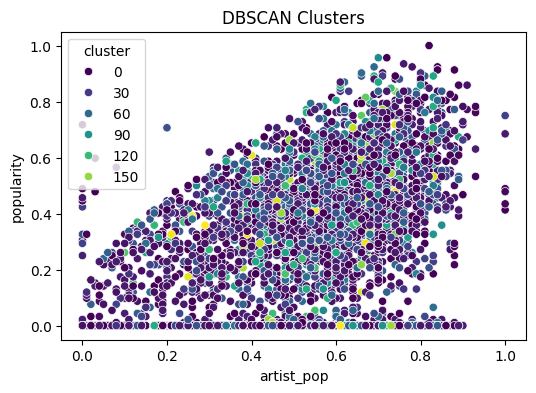

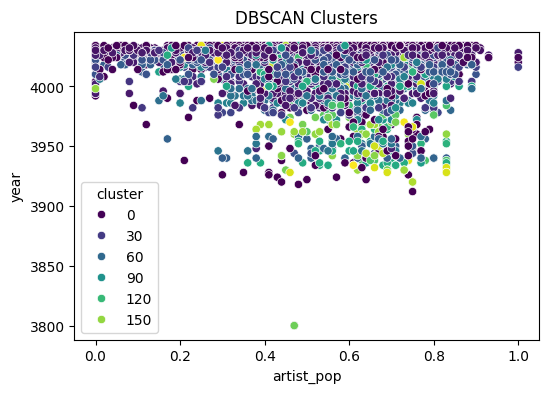

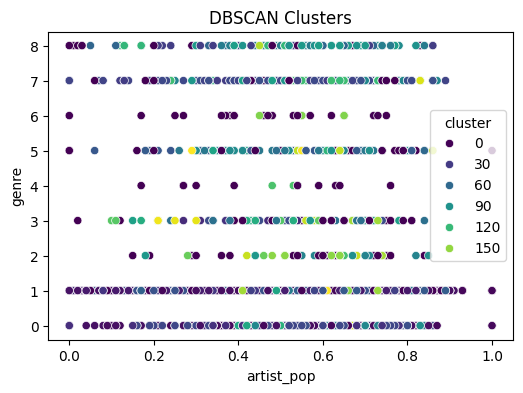

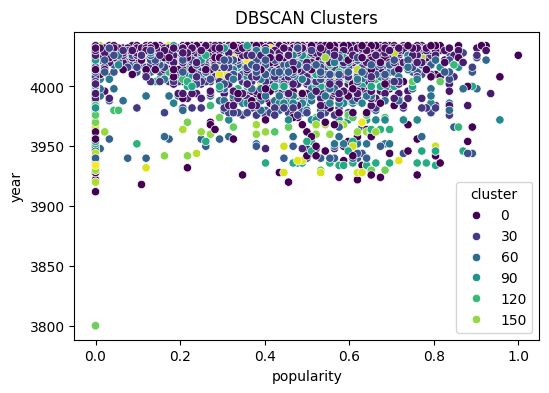

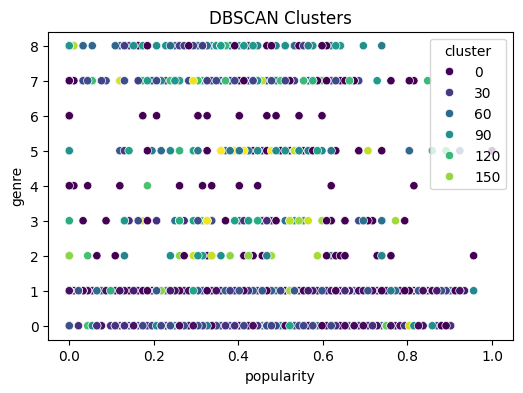

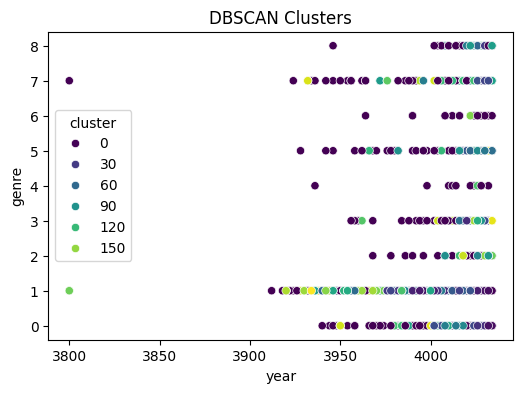

In [26]:
plotClusters('cluster','DBSCAN')

In [27]:
# Calculate centroid values
centroid_values = X.groupby('cluster')[features_for_clustering].mean()

print("Centroid values:")
print(centroid_values)

Centroid values:
         artist_pop  popularity    year     genre
cluster                                          
-1         0.521961    0.356405  3990.0  3.980392
 0         0.568000    0.283972  4034.0  1.000000
 1         0.529293    0.250000  4014.0  1.000000
 2         0.569395    0.242724  4024.0  1.000000
 3         0.558438    0.345788  4020.0  0.000000
...             ...         ...     ...       ...
 175       0.300000    0.326087  4024.0  3.000000
 176       0.595000    0.630435  3970.0  1.000000
 177       0.595000    0.445652  4032.0  5.000000
 178       0.610000    0.000000  3934.0  1.000000
 179       0.275000    0.375000  4022.0  5.000000

[181 rows x 4 columns]


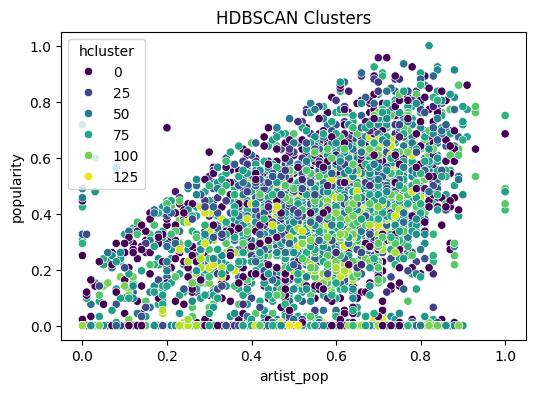

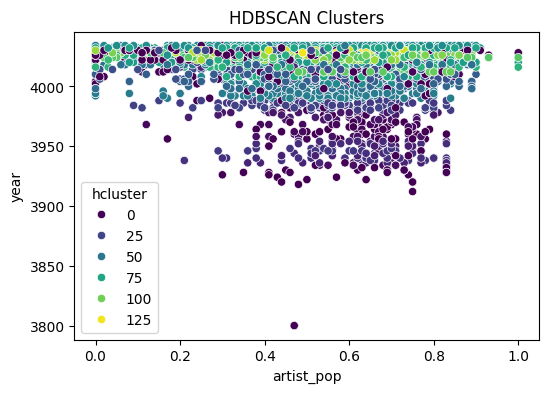

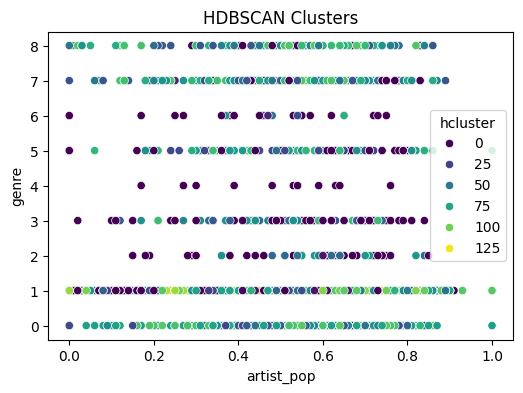

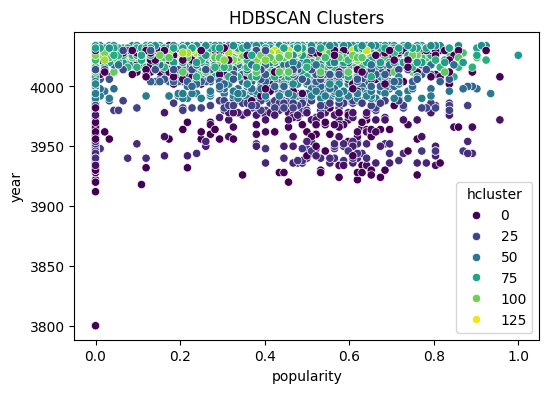

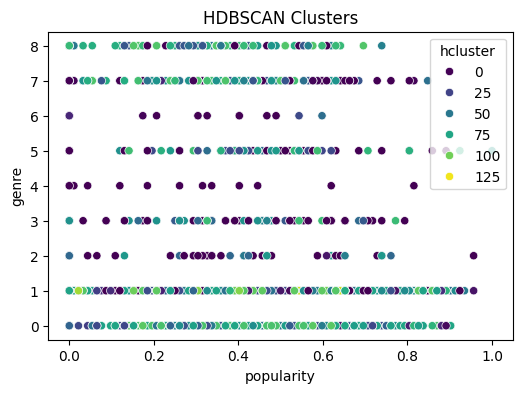

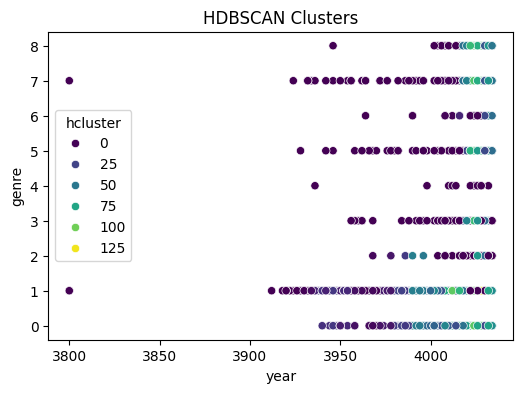

In [28]:
plotClusters('hcluster','HDBSCAN')

In [29]:
centroid_values = X.groupby('hcluster')[features_for_clustering].mean()

print("Centroid values:")
print(centroid_values)

Centroid values:
          artist_pop  popularity         year     genre
hcluster                                               
-1          0.502185    0.277371  4013.638205  2.017366
 0          0.702000    0.316667  3929.466667  1.000000
 1          0.593182    0.296443  4009.727273  7.000000
 2          0.520000    0.392210  3968.000000  1.000000
 3          0.643571    0.506211  3964.285714  0.785714
...              ...         ...          ...       ...
 124        0.520000    0.000000  4030.000000  1.000000
 125        0.492593    0.000403  4028.000000  1.000000
 126        0.568235    0.000639  4028.000000  1.000000
 127        0.577778    0.000000  4030.000000  1.000000
 128        0.610000    0.000000  4030.000000  1.000000

[130 rows x 4 columns]


In [30]:
# Count the number of clusters formed
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Exclude noise points if present (-1 indicates noise)
print("Number of clusters formed:", num_clusters)

Number of clusters formed: 180


In [31]:
num_clusters = len(set(hclusters)) - (1 if -1 in hclusters else 0)  # Exclude noise points if present (-1 indicates noise)
print("Number of clusters formed:", num_clusters)

Number of clusters formed: 129


Hierarchical clustering:

In [32]:
from sklearn.cluster import AgglomerativeClustering

In [33]:
# Hierarchical clustering
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarhical_clusters = hc.fit_predict(X)

In [34]:
#Add cluster labels to dataframe
X['hierarchical_cluster'] = hierarhical_clusters

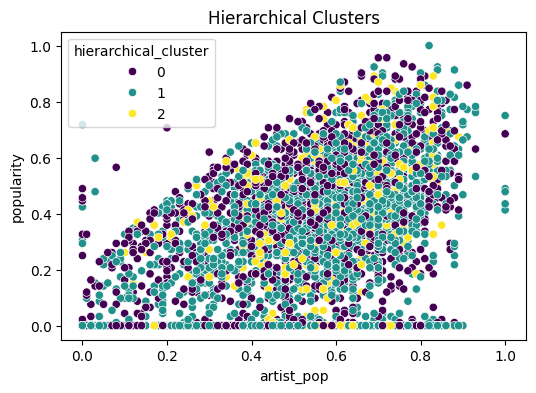

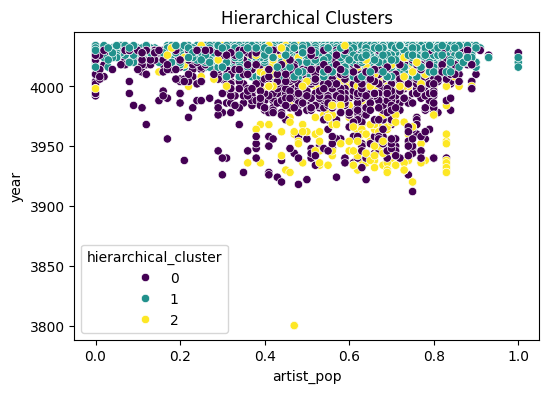

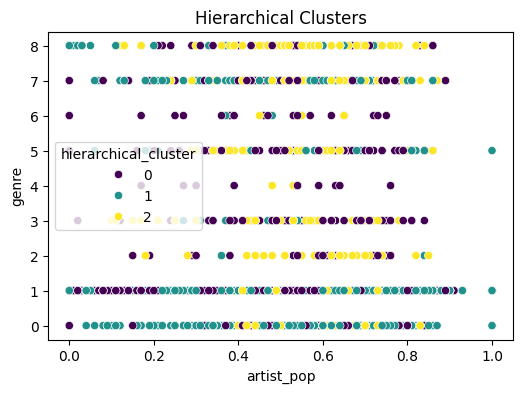

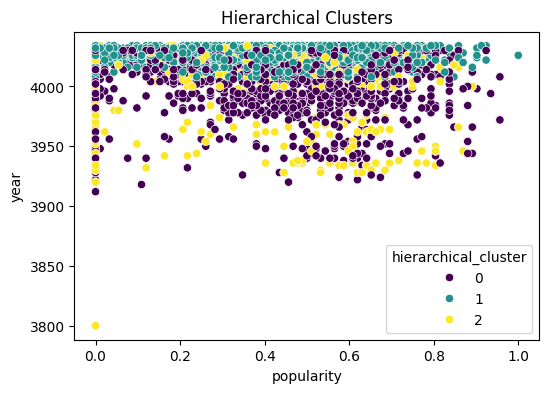

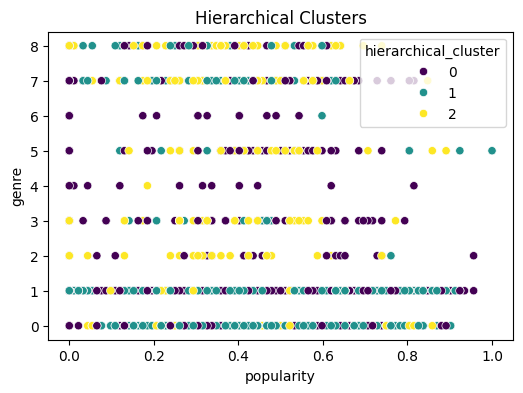

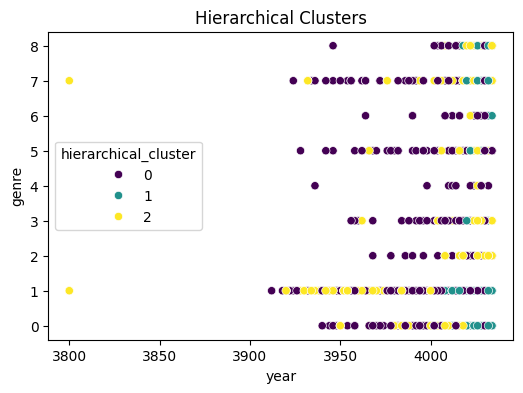

In [35]:
plotClusters('hierarchical_cluster','Hierarchical')

In [36]:
# Count the number of clusters formed
num_clusters_hc = len(set(hierarhical_clusters))
print("Number of clusters formed by hierarchical clustering:", num_clusters_hc)

Number of clusters formed by hierarchical clustering: 3


In [37]:
optics=OPTICS(min_samples=6,min_cluster_size=5)  # metric=weighted_distance

In [38]:
optics_clusters=optics.fit_predict(X)

In [39]:
X['ocluster'] = optics_clusters


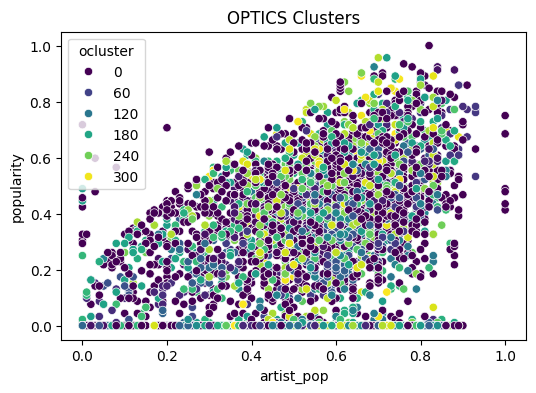

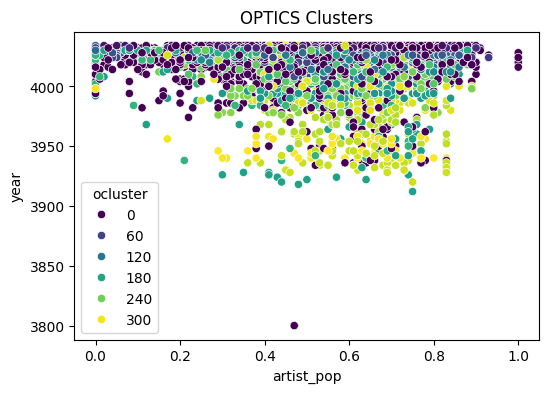

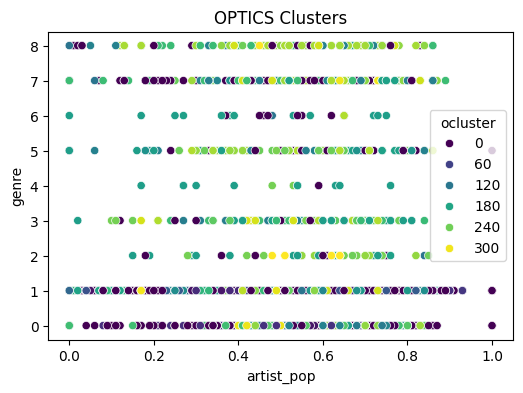

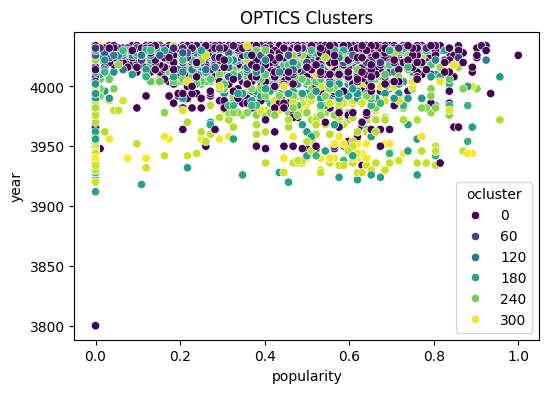

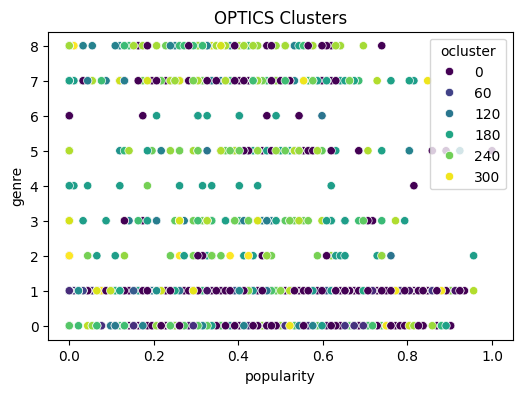

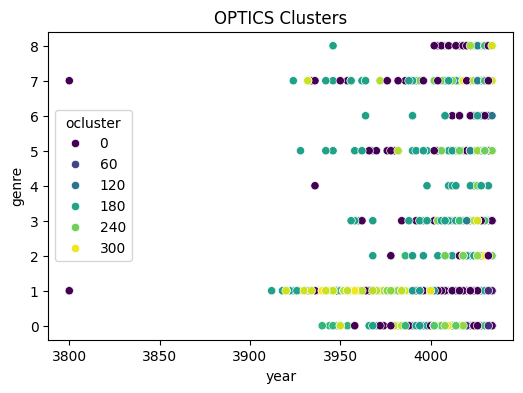

In [40]:
plotClusters('ocluster','OPTICS')

In [41]:
# Count the number of clusters formed
num_clusters_optics = len(set(optics_clusters)) - (1 if -1 in optics_clusters else 0)  # Exclude noise points if present (-1 indicates noise)
print("Number of clusters formed by OPTICS:", num_clusters_optics)

Number of clusters formed by OPTICS: 308


In [42]:
# Calculate centroid values
centroid_values = X.groupby('ocluster')[features_for_clustering].mean()

print("Centroid values:")
print(centroid_values)

Centroid values:
          artist_pop  popularity         year     genre
ocluster                                               
-1          0.541252    0.333221  4019.860752  1.315553
 0          0.380000    0.000000  4034.000000  1.000000
 1          0.436667    0.001208  4034.000000  1.000000
 2          0.601111    0.000000  4034.000000  1.000000
 3          0.641250    0.000000  4034.000000  1.000000
...              ...         ...          ...       ...
 303        0.630000    0.710145  3944.000000  1.000000
 304        0.580000    0.558424  3940.000000  1.000000
 305        0.683333    0.016304  3940.000000  1.000000
 306        0.580000    0.366221  3949.692308  1.000000
 307        0.567273    0.097826  4031.090909  3.636364

[309 rows x 4 columns]


In [51]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score

algoNames=['DBSCAN','HDBSCAN','Hierarchical','OPTICS','Birch']
cols=['Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score' ]# 'Adjusted Rand Score', 'Homogeneity Score', 'Completeness Score', 'V Measure Score']
 
results = pd.DataFrame(columns=cols, index=algoNames)

def evalClusteringAlgo(algoName,clusters,features=features_for_clustering):
    silhouette = silhouette_score(df[features], clusters)
    davies_bouldin = davies_bouldin_score(df[features], clusters)
    calinski_harabasz = calinski_harabasz_score(df[features], clusters)
    # adjusted_rand = adjusted_rand_score(df['genre'], clusters)
    # homogeneity = homogeneity_score(df['genre'], clusters)
    # completeness = completeness_score(df['genre'], clusters)
    # v_measure = v_measure_score(df['genre'], clusters)
    results.loc[algoName] = [silhouette, davies_bouldin, calinski_harabasz]# adjusted_rand, homogeneity, completeness, v_measure]
    
    

In [44]:
evalClusteringAlgo('DBSCAN',clusters)
evalClusteringAlgo('HDBSCAN',hclusters)
evalClusteringAlgo('Hierarchical',hierarhical_clusters) 
evalClusteringAlgo('OPTICS',optics_clusters)

results.head()

,Silhouette Score,Davies Bouldin Score,Calinski Harabasz Score,Adjusted Rand Score,Homogeneity Score,Completeness Score,V Measure Score
DBSCAN,0.590547,1.4956,220.642502,0.049449,0.910357,0.225751,0.361786
HDBSCAN,0.415076,2.147189,113.557534,0.026761,0.798051,0.193336,0.311266
Hierarchical,0.222418,4.205198,857.849497,0.122262,0.085266,0.088789,0.086992
OPTICS,-0.022026,2.844217,40.681223,0.05834,0.688257,0.157023,0.255707
Birch,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:

from sklearn.cluster import HDBSCAN, OPTICS, SpectralClustering, Birch, AgglomerativeClustering
#AffinityPropagation, MeanShift,

In [52]:
# Initialize clustering algorithms
hdbscan = HDBSCAN(min_cluster_size=7, min_samples=8, cluster_selection_method='eom',metric=weighted_distance, n_jobs=-1)
optics = OPTICS(min_samples=6, min_cluster_size=5, metric=weighted_distance, n_jobs=-1)
birch = Birch(n_clusters=7)
agglomerative = AgglomerativeClustering(n_clusters=3, linkage='ward')
# spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=10)

In [53]:
#combine all clustering algorithms
clustering_algorithms = (
    # ('HDBSCAN', hdbscan),
    # ('OPTICS', optics),
    ('Birch', birch),
    # ('Agglomerative', agglomerative),
    # ('Spectral', spectral)
)

# Iterate over each clustering algorithm
for name, algorithm in clustering_algorithms:
    # Fit the algorithm to the data
    clusters = algorithm.fit_predict(df[features_for_clustering])
    # Calculate silhouette score
    silhouette = silhouette_score(df[features_for_clustering], clusters)
    # Print the score
    print(f'Silhouette score for {name}:', silhouette)
    
    # Add cluster labels to dataframe
    df[name] = clusters


Silhouette score for Birch: 0.5761693711788777


In [48]:
# Save the dataframe to a CSV file
df.to_csv('../Data/Spotify_with_clusters.csv', index=False)

In [49]:
import pickle

# Save the model
with open('../Models/hdbscan.pkl', 'wb') as file:
    pickle.dump(hdbscan, file)

with open('../Models/optics.pkl', 'wb') as file:
    pickle.dump(optics, file)

with open('../Models/birch.pkl', 'wb') as file:
    pickle.dump(birch, file)
    
with open('../Models/agglomerative.pkl', 'wb') as file:
    pickle.dump(agglomerative, file)
